# **Mount Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# **Data Preprocessing**

In [2]:
# generic libraries

import pandas as pd
import numpy as np
from numba import jit
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import warnings
warnings.filterwarnings("ignore")

# ML specific libraries

from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge, RidgeCV, ElasticNetCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, fbeta_score, make_scorer, confusion_matrix, plot_confusion_matrix
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf

In [3]:
# one minute tick data
# take ~4 minutes to run to parse dates - be patient!

zfile = zipfile.ZipFile('/content/drive/MyDrive/datasets/1_min_SPY_2008-2021.zip')
zfile.extractall()
tick_data = pd.read_csv("1_min_SPY_2008-2021.csv", parse_dates=['date'], cache_dates=True).drop(columns="Unnamed: 0")
tick_data

,date,open,high,low,close,volume,barCount,average
0,2009-05-22 07:30:00,89.45,89.46,89.37,89.37,7872,2102,89.424
1,2009-05-22 07:31:00,89.38,89.53,89.37,89.50,5336,1938,89.468
2,2009-05-22 07:32:00,89.51,89.54,89.48,89.49,3349,1184,89.516
3,2009-05-22 07:33:00,89.49,89.49,89.31,89.34,3495,1240,89.386
4,2009-05-22 07:34:00,89.33,89.46,89.33,89.39,9731,2637,89.379
...,...,...,...,...,...,...,...,...
2070829,2010-12-22 13:55:00,125.73,125.73,125.71,125.71,1876,677,125.714
2070830,2010-12-22 13:56:00,125.71,125.74,125.71,125.74,4769,1011,125.724
2070831,2010-12-22 13:57:00,125.74,125.74,125.73,125.74,2602,588,125.738
2070832,2010-12-22 13:58:00,125.74,125.82,125.73,125.81,22953,2866,125.776


In [4]:
tick_data.dtypes

date        datetime64[ns]
open               float64
high               float64
low                float64
close              float64
volume               int64
barCount             int64
average            float64
dtype: object

In [5]:
tick_data['Date'] = tick_data['date'].apply(lambda x: x.strftime("%Y-%m-%d"))
cols = ['date','Date','open','high','low','close','volume','barCount','average']
tick_data = tick_data.sort_values(by='date', ascending=True).reset_index(drop=True)[cols]
tick_data

,date,Date,open,high,low,close,volume,barCount,average
0,2008-01-22 07:30:00,2008-01-22,126.45,126.82,126.00,126.67,30987,4541,126.283
1,2008-01-22 07:31:00,2008-01-22,126.67,127.17,126.39,127.12,20111,3125,126.958
2,2008-01-22 07:32:00,2008-01-22,127.10,127.13,126.71,126.78,11979,2074,126.922
3,2008-01-22 07:33:00,2008-01-22,126.76,126.90,126.53,126.54,8017,1350,126.675
4,2008-01-22 07:34:00,2008-01-22,126.54,127.18,126.54,126.78,11967,1253,126.730
...,...,...,...,...,...,...,...,...,...
2070829,2021-05-06 13:55:00,2021-05-06,418.56,418.77,418.48,418.49,9073,4584,418.660
2070830,2021-05-06 13:56:00,2021-05-06,418.50,418.73,418.47,418.64,6680,3095,418.622
2070831,2021-05-06 13:57:00,2021-05-06,418.64,418.79,418.63,418.79,6912,2868,418.744
2070832,2021-05-06 13:58:00,2021-05-06,418.79,418.83,418.71,418.76,7891,3862,418.784


In [6]:
# get start and end dates for weekly dates

start_date = pd.to_datetime(tick_data['Date'].sort_values(ascending=True).iloc[0])
end_date = pd.to_datetime(tick_data['Date'].sort_values(ascending=True).iloc[-1])
print(f"Start date: {start_date} and end date: {end_date}")

Start date: 2008-01-22 00:00:00 and end date: 2021-05-06 00:00:00


In [7]:
business_month_end_dates = pd.date_range(start_date, end_date, freq="bm")

In [8]:
# China composite index

china_index = pd.read_csv("/content/drive/MyDrive/datasets/000001.SS.csv")
china_index_returns = china_index.set_index('Date')['Adj Close'].pct_change().to_frame().rename(columns={'Adj Close':"SSE Composite Return"}).fillna(0)
china_index_returns

,SSE Composite Return
Date,
2008-01-22,0.000000
2008-01-23,0.031426
2008-01-24,0.003123
2008-01-25,0.009317
2008-01-28,-0.071906
...,...
2021-04-26,-0.009499
2021-04-27,0.000419
2021-04-28,0.004200


In [9]:
# ADS index

ads_index = pd.read_excel("/content/drive/MyDrive/datasets/ADS_Index_Most_Current_Vintage.xlsx") \
            .rename(columns={"Unnamed: 0":'Date'})
ads_index['Date'] = pd.to_datetime(ads_index['Date'].apply(lambda x: x.replace(":","-")))
ads_index = ads_index.set_index('Date')
ads_index = ads_index[ads_index.index.isin(tick_data['Date'])]
ads_index

,ADS_Index
Date,
2008-01-22,-0.723470
2008-01-23,-0.737825
2008-01-24,-0.750757
2008-01-25,-0.762268
2008-01-28,-0.790995
...,...
2021-04-30,0.368254
2021-05-03,0.316099
2021-05-04,0.300719


In [10]:
# Dividend history

div_hist = pd.read_excel("/content/drive/MyDrive/datasets/Dividend_History_SP500.xlsx", parse_dates=['Ex-Dividend Date']) \
            .set_index('Ex-Dividend Date').drop(columns=['Dividend Amount'])
div_hist['Indicator'] = 1
div_hist = div_hist[div_hist.index.isin(ads_index.index)].reindex(ads_index.index, fill_value=0)
div_hist

,Indicator
Date,
2008-01-22,0
2008-01-23,0
2008-01-24,0
2008-01-25,0
2008-01-28,0
...,...
2021-04-30,0
2021-05-03,0
2021-05-04,0


In [11]:
# Treasury yields

treasury_yields = pd.read_csv("/content/drive/MyDrive/datasets/Treasury_yields.csv", parse_dates=['Date'])
treasury_yields = treasury_yields[['Date', ' Close']].set_index('Date').rename(columns={' Close':"Treasury_Yields"})
treasury_yields

,Treasury_Yields
Date,
2021-05-06,0.010
2021-05-05,0.013
2021-05-04,0.015
2021-05-03,0.015
2021-04-30,0.010
...,...
2008-01-28,2.118
2008-01-25,2.098
2008-01-24,2.098


In [12]:
# Recession Indicator

rec_ind = pd.read_csv("/content/drive/MyDrive/datasets/USRECDM.csv", parse_dates=['DATE']).rename(columns={'DATE':'Date'})
rec_ind = rec_ind.set_index('Date')
rec_ind

,USRECDM
Date,
2008-01-22,1
2008-01-23,1
2008-01-24,1
2008-01-25,1
2008-01-26,1
...,...
2021-05-02,0
2021-05-03,0
2021-05-04,0


In [13]:
# Uncertainity data

uncertain_data = pd.read_excel("/content/drive/MyDrive/datasets/US_Policy_Uncertainty_Data.xlsx", skipfooter=1)
uncertain_data['Day'] = 1
uncertain_data['Month_Date'] = pd.to_datetime(uncertain_data[['Year', 'Month', 'Day']], errors='coerce').apply(lambda x: x.strftime("%Y-%m"))
uncertain_data = uncertain_data.drop(columns=['Year', 'Month', 'Day'])[['Month_Date', 'Three_Component_Index', 'News_Based_Policy_Uncert_Index']]
uncertain_data

,Month_Date,Three_Component_Index,News_Based_Policy_Uncert_Index
0,1985-01,125.224739,103.748802
1,1985-02,99.020813,78.313202
2,1985-03,112.190506,100.761482
3,1985-04,102.811325,84.778870
4,1985-05,120.082726,98.053658
...,...,...,...
436,2021-05,147.015839,172.096191
437,2021-06,133.578857,149.131256
438,2021-07,152.910904,182.171417
439,2021-08,133.876297,157.300735


In [14]:
# Taiwan index

taiwan_index = pd.read_csv("/content/drive/MyDrive/datasets/^TWII.csv")
taiwan_index_returns = taiwan_index.set_index('Date')['Adj Close'].pct_change().to_frame().rename(columns={'Adj Close':"TAIEX MktCap Return"}).fillna(0)
taiwan_index_returns

,TAIEX MktCap Return
Date,
2008-01-22,0.000000
2008-01-23,-0.022891
2008-01-24,0.014666
2008-01-25,0.029605
2008-01-28,-0.032792
...,...
2021-04-28,-0.001612
2021-04-29,-0.000049
2021-05-03,-0.019600


In [15]:
# VIX

vix = pd.read_csv("/content/drive/MyDrive/datasets/^VIX.csv")
vix = vix.set_index('Date')['Adj Close'].to_frame().rename(columns={'Adj Close':"VIX"})
vix

,VIX
Date,
2008-01-22,31.010000
2008-01-23,29.020000
2008-01-24,27.780001
2008-01-25,29.080000
2008-01-28,27.780001
...,...
2021-04-29,17.610001
2021-04-30,18.610001
2021-05-03,18.309999


# **Data Analysis**

In [16]:
# compute returns

ret_cols = ['date','Date','close']
data_returns = tick_data[ret_cols]#.set_index('date')
data_returns['ret'] = data_returns['close'].pct_change()
data_returns

,date,Date,close,ret
0,2008-01-22 07:30:00,2008-01-22,126.67,NaN
1,2008-01-22 07:31:00,2008-01-22,127.12,0.003553
2,2008-01-22 07:32:00,2008-01-22,126.78,-0.002675
3,2008-01-22 07:33:00,2008-01-22,126.54,-0.001893
4,2008-01-22 07:34:00,2008-01-22,126.78,0.001897
...,...,...,...,...
2070829,2021-05-06 13:55:00,2021-05-06,418.49,-0.000167
2070830,2021-05-06 13:56:00,2021-05-06,418.64,0.000358
2070831,2021-05-06 13:57:00,2021-05-06,418.79,0.000358
2070832,2021-05-06 13:58:00,2021-05-06,418.76,-0.000072


In [17]:
# compute daily volatility from the S&P 500 tick data

daily_std = data_returns.groupby('Date')['ret'].std().to_frame().rename(columns={'ret':'daily_vol'})
daily_std

,daily_vol
Date,
2008-01-22,0.001293
2008-01-23,0.001896
2008-01-24,0.000898
2008-01-25,0.000544
2008-01-28,0.000731
...,...
2021-04-30,0.000239
2021-05-03,0.000335
2021-05-04,0.000460


In [18]:
data_returns['Date'] = pd.to_datetime(data_returns['Date'])
data_returns.dtypes

date     datetime64[ns]
Date     datetime64[ns]
close           float64
ret             float64
dtype: object

In [19]:
# compute weekly volatility from the S&P 500 tick data

daily_ret = data_returns[['Date','ret']].groupby('Date')['ret'].apply(lambda x: (1+x).prod()-1).to_frame()
daily_ret = daily_ret.fillna(0)

weekly_std = pd.DataFrame(daily_ret.rolling(5).std(), index=daily_ret.index).rename(columns={'ret':'rolling_weekly_vol'})
# # weekly_std = data_returns.set_index('date').resample('W')['ret'].std().to_frame().rename(columns={'ret':'weekly_vol'})
weekly_std.head(10)

,rolling_weekly_vol
Date,
2008-01-22,NaN
2008-01-23,NaN
2008-01-24,NaN
2008-01-25,NaN
2008-01-28,0.017698
2008-01-29,0.014656
2008-01-30,0.012093
2008-01-31,0.014170
2008-02-01,0.010919


#### 1. ADS Index

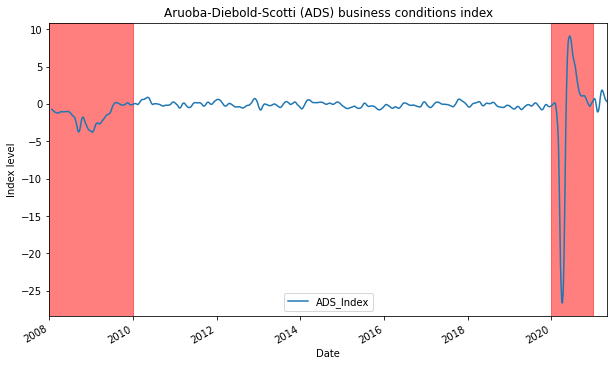

In [20]:
ads_index.plot(figsize=(10,6), title="Aruoba-Diebold-Scotti (ADS) business conditions index")
plt.axvspan("2008", "2010", color='red', alpha=0.5);
plt.axvspan("2020", "2021", color='red', alpha=0.5);
plt.margins(x=0)
plt.ylabel('Index level')
plt.savefig('ads.png',dpi=1000)

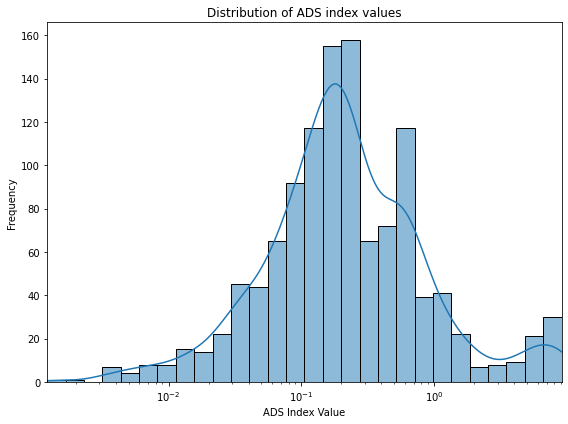

In [21]:
fig, ax = plt.subplots(figsize = (8,6))
ax = sns.histplot(data = ads_index, x = "ADS_Index", kde=True, log_scale=True)
ax.margins(x = 0)
ax.set_ylabel("Frequency")
ax.set_xlabel("ADS Index Value")
ax.set_title("Distribution of ADS index values")
plt.tight_layout()
plt.savefig('ads_dist.png',dpi=1000)

#### 2. US Recession Indicator (NBER)

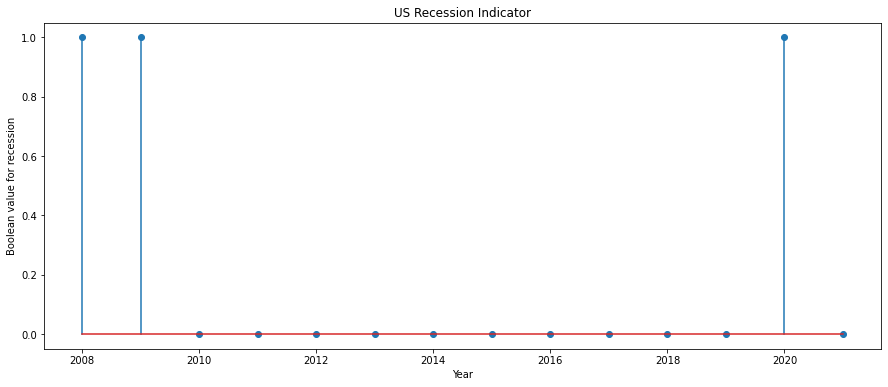

In [22]:
rec_ind['Year'] = rec_ind.index.year
rec_ind_heatmap = rec_ind.groupby('Year')['USRECDM'].max().to_frame()
x = list(rec_ind_heatmap.USRECDM)
y = list(rec_ind_heatmap.index)
fig, ax = plt.subplots(figsize = (15,6))
plt.stem(y,x)
plt.title('US Recession Indicator')
plt.xlabel('Year')
plt.ylabel('Boolean value for recession')
plt.savefig('us_rec.png',dpi=1000)

#### 3. Dividend History

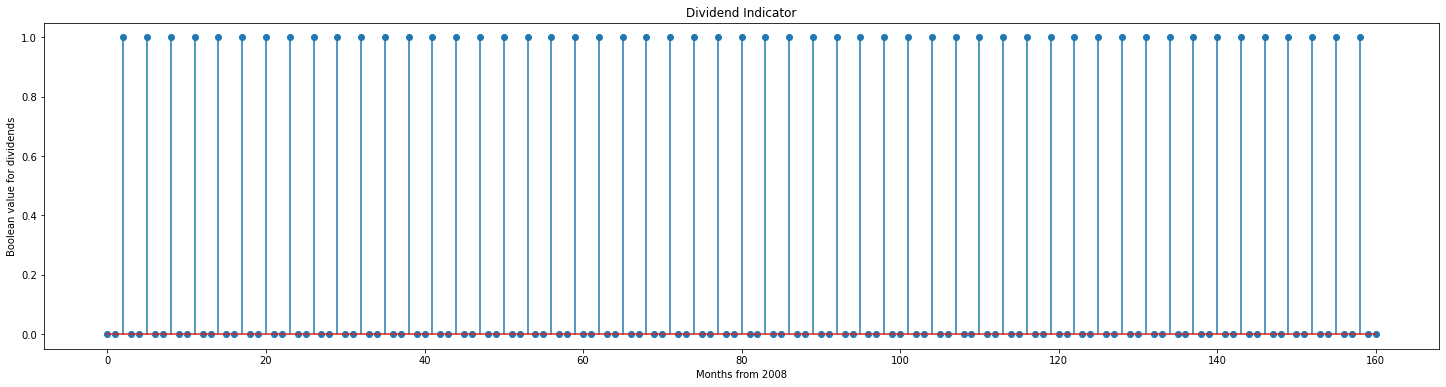

In [23]:
div_hist['month_year'] = div_hist.index.to_period('M')
div_hist_heatmap = div_hist.groupby('month_year')['Indicator'].max().to_frame()
x = list(div_hist_heatmap.Indicator)
y = list(div_hist_heatmap.index.astype(str))

fig, ax = plt.subplots(figsize = (25,6))
plt.stem(x)
plt.title('Dividend Indicator')
plt.xlabel('Months from 2008')
plt.ylabel('Boolean value for dividends')
plt.savefig('div_ind.png',dpi=1000)

#### 4. China SSE Composite Index vs Taiwan Stock Index

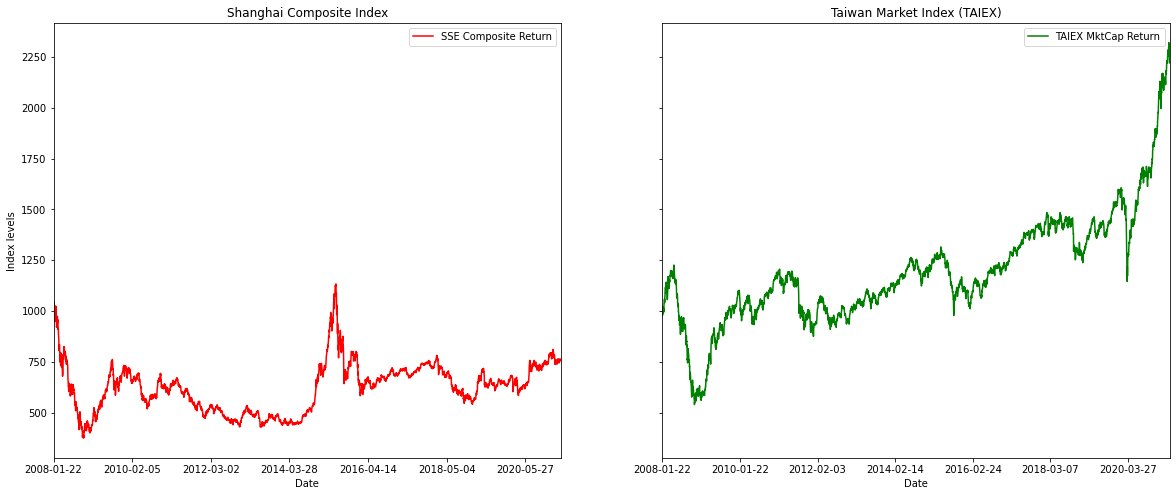

In [24]:
china_index_rebased = (1 + china_index_returns).cumprod() * 1000
taiwan_index_rebased = (1 + taiwan_index_returns).cumprod() * 1000

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8), sharey=True)
china_index_rebased.plot(color='red', ax=ax1, title="Shanghai Composite Index");
ax1.set_ylabel('Index levels')
ax1.margins(x=0)
taiwan_index_rebased.plot(color='green', ax=ax2, title="Taiwan Market Index (TAIEX)");
ax2.set_ylabel('Index levels')
ax2.margins(x=0)

plt.savefig('china_taiwan_index.png',dpi=1000)

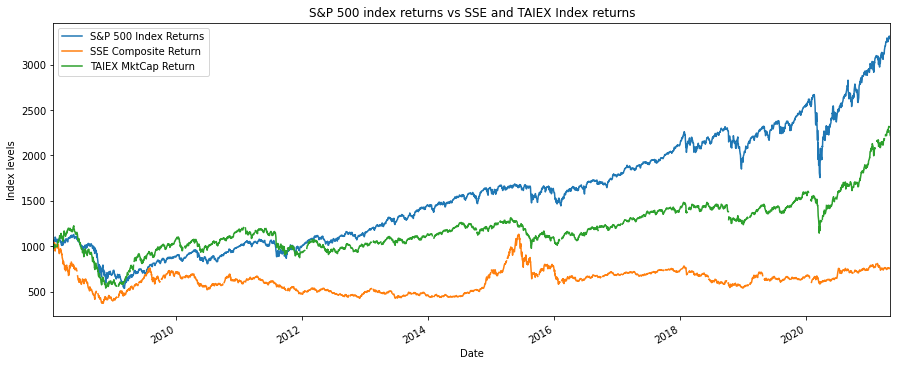

In [25]:
us_index_rebased = (1 + daily_ret).cumprod() * 1000
ret_plot_compare = us_index_rebased.join(china_index_rebased).join(taiwan_index_rebased).rename(columns={'ret':'S&P 500 Index Returns'})

ret_plot_compare.plot(figsize=(15,6))
plt.ylabel('Index levels')
plt.title('S&P 500 index returns vs SSE and TAIEX Index returns')
plt.margins(x=0)

plt.savefig('compare_index.png',dpi=1000)

Gaps are seen in the time series of TAIEX, SSE index and S&P 500. This has be explained because the trading days in US are different from China and Taiwan. We have backfilled these dates because in absence of price levels we are assuming that the return is 0 so the price level remains the same as the last day.

In [26]:
# Compare S&P 500 index vs China and Taiwan
ret_plot_compare = us_index_rebased.join(china_index_rebased).join(taiwan_index_rebased).rename(columns={'ret':'S&P 500 Index Returns'})
ret_plot_compare['SSE Composite Return'] = ret_plot_compare['SSE Composite Return'].fillna(method='ffill')
ret_plot_compare['TAIEX MktCap Return'] = ret_plot_compare['TAIEX MktCap Return'].fillna(method='ffill')
ret_plot_compare['SSE Composite Return'].iloc[0] = 1000
ret_plot_compare['TAIEX MktCap Return'].iloc[0] = 1000
ret_plot_compare

,S&P 500 Index Returns,SSE Composite Return,TAIEX MktCap Return
Date,,,
2008-01-22,1031.262335,1000.000000,1000.000000
2008-01-23,1057.472172,1031.426255,977.108855
2008-01-24,1065.129865,1034.647267,991.438900
2008-01-25,1050.367096,1044.286851,1020.790202
2008-01-28,1067.498224,969.196337,987.316036
...,...,...,...
2021-04-30,3294.386990,755.931656,2316.911062
2021-05-03,3301.255230,755.931656,2271.499076
2021-05-04,3281.361017,755.931656,2233.438811


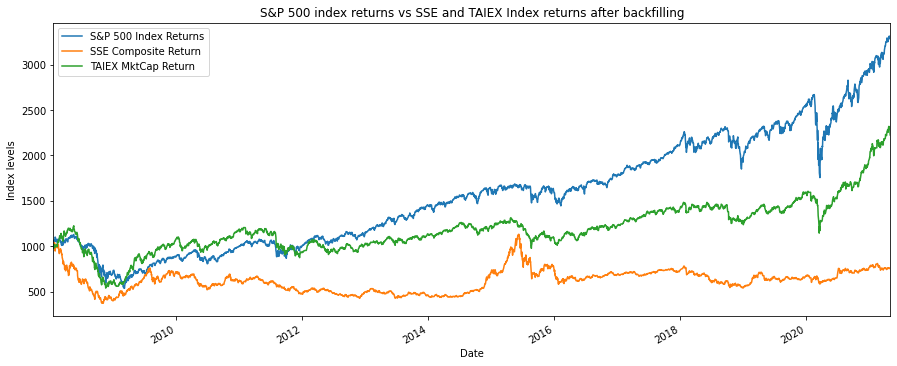

In [27]:
ret_plot_compare.plot(figsize=(15,6))
plt.ylabel('Index levels')
plt.title('S&P 500 index returns vs SSE and TAIEX Index returns after backfilling')
plt.margins(x=0)
plt.savefig('compare_index_no_gaps.png',dpi=1000)

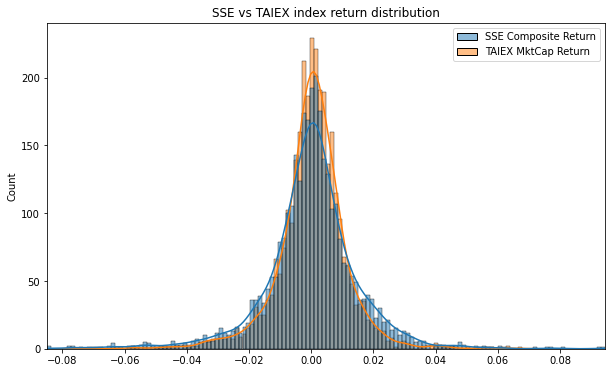

In [28]:
supply_chain_df = china_index_returns.join(taiwan_index_returns)

fig, ax = plt.subplots(figsize = (10,6))
ax = sns.histplot(data = supply_chain_df, kde=True)
ax.margins(x = 0)
ax.set_title("SSE vs TAIEX index return distribution")
plt.savefig('index_dist.png',dpi=1000)

#### 5. VIX

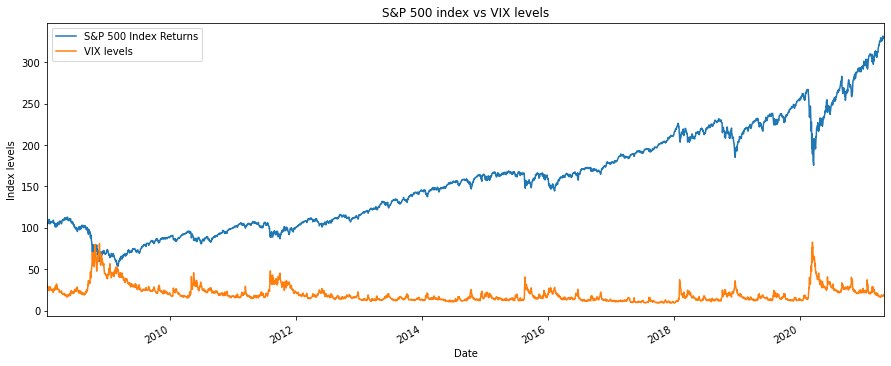

In [29]:
#VIX and SP500 returns plot
vix_compare=vix
us_index_rebased = (1 + daily_ret).cumprod() * 100
vix_plot_compare = us_index_rebased.join(vix_compare['VIX']).rename(columns={'ret':'S&P 500 Index Returns','VIX':'VIX levels'})

vix_plot_compare.plot(figsize=(15,6))
plt.title('S&P 500 index vs VIX levels')
plt.ylabel('Index levels')
plt.margins(x=0)
plt.savefig('snp_vix.png',dpi=1000)

#### 6. Volume

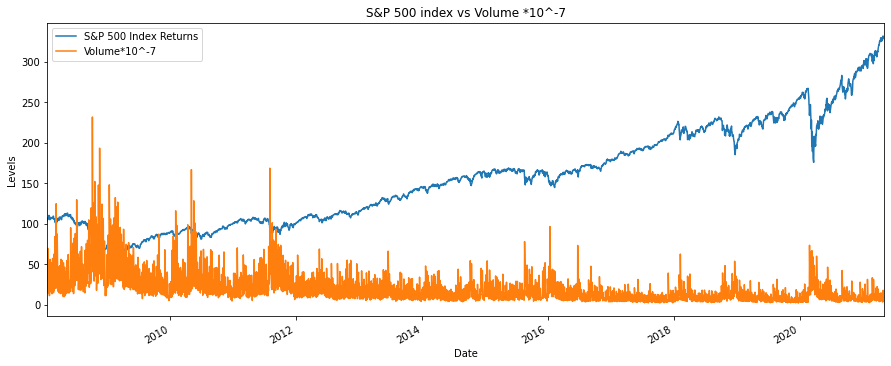

In [30]:
daily_vol = tick_data.groupby('Date').sum()['volume'].to_frame()

us_index_rebased = (1 + daily_ret).cumprod() * 100
daily_vol_compare = us_index_rebased.join(daily_vol['volume']/100000).rename(columns={'ret':'S&P 500 Index Returns','volume':'Volume*10^-7'})

daily_vol_compare.plot(figsize=(15,6))
plt.title('S&P 500 index vs Volume *10^-7')
plt.ylabel('Levels')
plt.margins(x=0)
plt.savefig('snp_vol.png',dpi=1000)

#### 7. Treasury yields

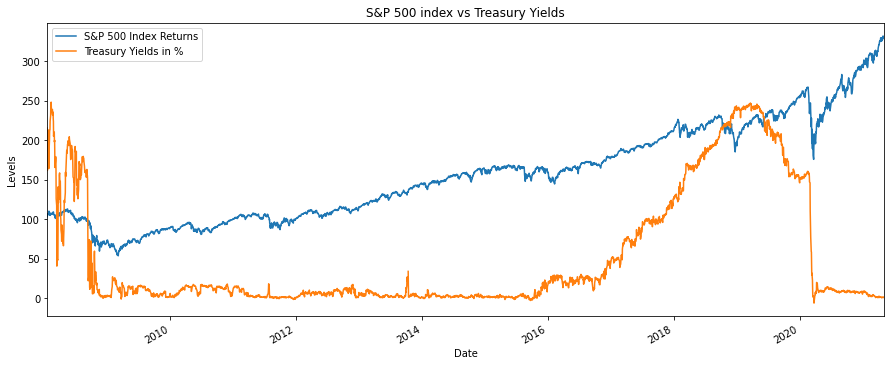

In [31]:
treasury_compare=treasury_yields

us_index_rebased = (1 + daily_ret).cumprod() * 100
treasury_compare = us_index_rebased.join(treasury_compare['Treasury_Yields']*100).rename(columns={'ret':'S&P 500 Index Returns','Treasury_Yields':'Treasury Yields in %'})

treasury_compare.plot(figsize=(15,6))
plt.title('S&P 500 index vs Treasury Yields')
plt.ylabel('Levels')
plt.margins(x=0)
plt.savefig('snp_treasury.png',dpi=1000)

We can clearly see that because of quantitative easing in 2020, teasury yields drop and the stock market starts rallying again. The same effect is seen from 2008 to 2016 as well.

#### 8. Uncertainity Data

In [32]:
monthly_returns = us_index_rebased[us_index_rebased.index.isin(business_month_end_dates)].pct_change()*1000
monthly_returns.index = monthly_returns.index.strftime("%Y-%m")
monthly_returns

,ret
Date,
2008-01,NaN
2008-02,-25.782957
2008-03,-13.980263
2008-04,49.283494
2008-05,13.584797
...,...
2020-12,27.612329
2021-01,-13.194797
2021-02,29.178509


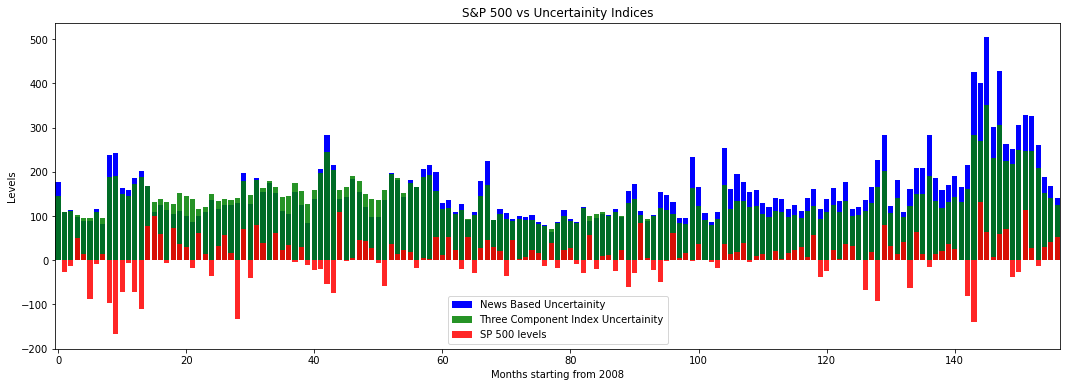

In [33]:
uncertain_compare=uncertain_data
uncertain_compare=uncertain_compare.set_index('Month_Date')
uncertain_compare = monthly_returns.join(uncertain_compare).rename(columns={'ret':'S&P 500 Index Levels'})

width = 0.8

indices = np.arange(len(uncertain_compare['S&P 500 Index Levels']))
f, ax = plt.subplots(figsize=(18,6))
plt.bar(indices, uncertain_compare['News_Based_Policy_Uncert_Index'], width=width, color='b', label='News Based Uncertainity')
plt.bar(indices, uncertain_compare['Three_Component_Index'], width=width, color='g', alpha=0.85, label='Three Component Index Uncertainity')
plt.bar(indices, uncertain_compare['S&P 500 Index Levels'], width=width, color='r', alpha=0.85, label='SP 500 levels')
plt.xlabel('Months starting from 2008')
plt.ylabel('Levels')
plt.title('S&P 500 vs Uncertainity Indices')
plt.legend()
plt.margins(x=0)
plt.savefig('snp_uncertain.png',dpi=1000)

# **Linear Models**

In [34]:
# Run linear regression with regularization terms - L1, L2 and maybe elastic net (not covered in class)
dependent_variable = daily_std

independent_variables = china_index_returns.join(taiwan_index_returns).join(ads_index).join(rec_ind) \
                                         .join(treasury_yields).join(div_hist).join(vix)

In [35]:
data = dependent_variable.join(independent_variables)

In [36]:
# fill missing values

data['month_date'] = data.index.strftime("%Y-%m")
data = pd.merge(data.reset_index(), uncertain_data, how='left', left_on="month_date", right_on="Month_Date").drop(columns=["month_date", "Month_Date"])
data.Date = pd.to_datetime(data.Date)
data = data.set_index("Date").drop(columns=['month_year','Year'])

cols = ['ADS_Index','SSE Composite Return','TAIEX MktCap Return','VIX','Treasury_Yields']
for col in cols:
    data[col] = data[col].fillna(method='ffill')

cols_2 = ['Indicator', 'USRECDM']
for col in cols_2:
    data[col] = data[col].fillna(0)

data

,daily_vol,SSE Composite Return,TAIEX MktCap Return,ADS_Index,USRECDM,Treasury_Yields,Indicator,VIX,Three_Component_Index,News_Based_Policy_Uncert_Index
Date,,,,,,,,,,
2008-01-22,0.001293,0.000000,0.000000,-0.723470,1.0,2.153,0.0,31.010000,144.984726,177.042206
2008-01-23,0.001896,0.031426,-0.022891,-0.737825,1.0,1.615,0.0,29.020000,144.984726,177.042206
2008-01-24,0.000898,0.003123,0.014666,-0.750757,1.0,2.098,0.0,27.780001,144.984726,177.042206
2008-01-25,0.000544,0.009317,0.029605,-0.762268,1.0,2.098,0.0,29.080000,144.984726,177.042206
2008-01-28,0.000731,-0.071906,-0.032792,-0.790995,1.0,2.118,0.0,27.780001,144.984726,177.042206
...,...,...,...,...,...,...,...,...,...,...
2021-04-30,0.000239,-0.008069,-0.000049,0.368254,0.0,0.010,0.0,18.610001,124.889526,141.300171
2021-05-03,0.000335,-0.008069,-0.000049,0.368254,0.0,0.010,0.0,18.610001,147.015839,172.096191
2021-05-04,0.000460,-0.008069,-0.000049,0.368254,0.0,0.010,0.0,18.610001,147.015839,172.096191


In [37]:
data.describe()

,daily_vol,SSE Composite Return,TAIEX MktCap Return,ADS_Index,USRECDM,Treasury_Yields,Indicator,VIX,Three_Component_Index,News_Based_Policy_Uncert_Index
count,3347.000000,3347.000000,3347.000000,3347.000000,3347.000000,3347.000000,3347.000000,3347.000000,3347.000000,3347.000000
mean,0.000442,0.000157,0.000363,-0.397405,0.109949,0.518894,0.015238,20.177825,139.664200,156.808603
std,0.000391,0.015316,0.011231,2.587689,0.312873,0.753193,0.122515,9.903879,46.731769,70.803920
min,0.000049,-0.084909,-0.063125,-26.650400,0.000000,-0.061000,0.000000,9.140000,71.262146,63.877335
25%,0.000228,-0.006324,-0.004546,-0.442512,0.000000,0.033000,0.000000,13.630000,104.190811,108.396095
50%,0.000336,0.000664,0.000806,-0.148233,0.000000,0.104000,0.000000,17.280001,131.750702,137.859711
75%,0.000516,0.007294,0.005955,0.113641,0.000000,0.834500,0.000000,23.355001,162.629120,180.803543
max,0.006173,0.094551,0.067422,9.079900,1.000000,2.480000,1.000000,82.690002,350.459839,503.963348


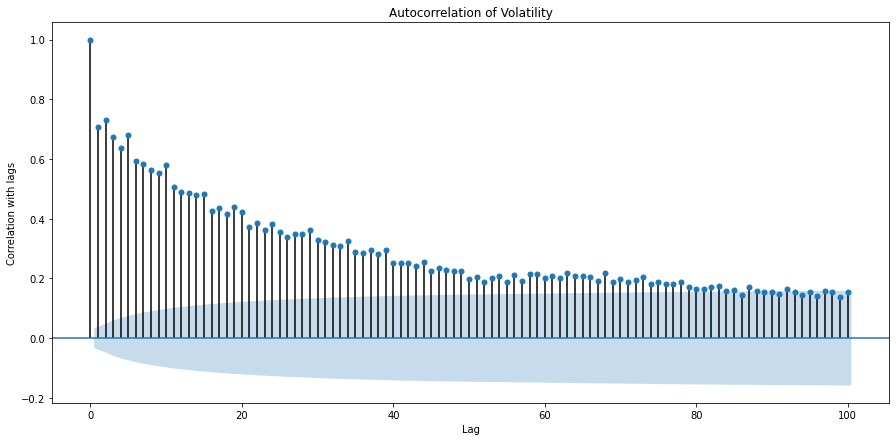

In [38]:
# Computing mean and acf of the net returns
acf_daily_vol=pd.DataFrame(acf(data['daily_vol']),columns=['ACF values'])

# Plotting acf
N, M = 15, 7
fig, ax = plt.subplots(figsize=(N, M))
plot_acf((data['daily_vol']*1000).values,lags=100,title='Autocorrelation of Volatility',ax=ax)
ax.set_xlabel('Lag')
ax.set_ylabel('Correlation with lags')
plt.savefig('auto_corr.png',dpi=1000)

From the ACF graph, we can see correlation being the largest with 5 days (1 week) and 20 days (1 month) hence we will be taking those lag values for daily volatility

In [39]:
# add lag variables

data_new = data
data_new['5_day_lag']=data_new['daily_vol'].shift(5)
data_new['20_day_lag']=data_new['daily_vol'].shift(20)
data_new

data_new = data_new.dropna()
data_new.isna().sum()
data = data_new

In [40]:
# normalise and train test split

cols = ['ADS_Index','SSE Composite Return','TAIEX MktCap Return','VIX','Treasury_Yields', 'Three_Component_Index', 'News_Based_Policy_Uncert_Index', '5_day_lag', '20_day_lag']
for col in cols:
    data[col] = data[col]-data[col].min()/(data[col].max()-data[col].min())

X = data.drop(columns=['daily_vol']).values
Y = (data['daily_vol']*1000).values

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=10)

In [41]:
# OLS

X_train = sm.add_constant(X_train)
mod = sm.OLS(y_train, X_train)
res = mod.fit(cov_type='HC1')
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.684
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     135.6
Date:                Mon, 01 Nov 2021   Prob (F-statistic):          2.24e-247
Time:                        00:00:20   Log-Likelihood:                 194.92
No. Observations:                2661   AIC:                            -365.8
Df Residuals:                    2649   BIC:                            -295.2
Df Model:                          11                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9388      0.534      5.505      0.0

In [42]:
# check collinearity

def high_corr(value):
    color = 'red' if value > 0.5 or value < -0.5 else 'black'
    return 'color: %s' % color

temp = data.drop(columns=['daily_vol'])
corr = temp.corr()
df=pd.DataFrame(corr)
corr_mat=df.style.applymap(high_corr)
corr_mat

,SSE Composite Return,TAIEX MktCap Return,ADS_Index,USRECDM,Treasury_Yields,Indicator,VIX,Three_Component_Index,News_Based_Policy_Uncert_Index,5_day_lag,20_day_lag
SSE Composite Return,1.000000,0.335298,0.005632,-0.033261,-0.035798,0.020260,-0.049441,0.001713,-0.004956,-0.033931,-0.000246
TAIEX MktCap Return,0.335298,1.000000,0.007627,-0.031958,-0.015181,0.042450,-0.077447,0.022805,0.011013,-0.022614,0.038296
ADS_Index,0.005632,0.007627,1.000000,-0.408454,-0.009846,-0.003775,-0.384770,-0.137644,-0.195050,-0.397438,-0.439350
USRECDM,-0.033261,-0.031958,-0.408454,1.000000,0.109891,0.004678,0.589372,0.070858,0.052288,0.500028,0.459176
Treasury_Yields,-0.035798,-0.015181,-0.009846,0.109891,1.000000,-0.003723,-0.204795,-0.162695,0.036559,-0.094730,-0.102064
Indicator,0.020260,0.042450,-0.003775,0.004678,-0.003723,1.000000,0.004332,0.009324,0.008941,-0.038548,0.010262
VIX,-0.049441,-0.077447,-0.384770,0.589372,-0.204795,0.004332,1.000000,0.511336,0.399477,0.739512,0.613827
Three_Component_Index,0.001713,0.022805,-0.137644,0.070858,-0.162695,0.009324,0.511336,1.000000,0.909407,0.297661,0.263564
News_Based_Policy_Uncert_Index,-0.004956,0.011013,-0.195050,0.052288,0.036559,0.008941,0.399477,0.909407,1.000000,0.251401,0.201822
5_day_lag,-0.033931,-0.022614,-0.397438,0.500028,-0.094730,-0.038548,0.739512,0.297661,0.251401,1.000000,0.485962


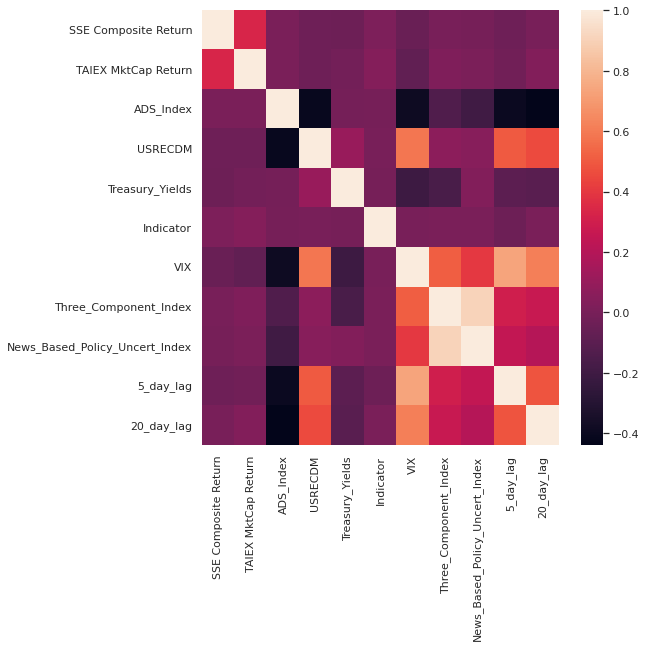

In [43]:
# heatmap

sns.set(rc={'figure.figsize':(8,8)})
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns)
plt.show()

In [44]:
# !pip install collinearity
# from collinearity import SelectNonCollinear

# X = data.drop(columns=['daily_vol'])
# Y = data['daily_vol']*1000
# features = ['SSE Composite Return', 'TAIEX MktCap Return', 'ADS_Index', 'USRECDM', 'Treasury_Yields', 'Indicator', 'VIX', 'Three_Component_Index', 'News_Based_Policy_Uncert_Index']

# sns.set(rc={'figure.figsize':(12,8)})
# sns.heatmap(X.corr(),annot=True)
# selector = SelectNonCollinear(0.5)
# X = np.array(X)
# selector.fit(X,Y)

In [45]:
# mask = selector.get_support()
# df2 = pd.DataFrame(X[:,mask],columns = np.array(features)[mask])
# sns.heatmap(df2.corr(),annot=True)

In [46]:
# remove collinear features

cols = ['ADS_Index','SSE Composite Return','VIX','TAIEX MktCap Return','Treasury_Yields', 'News_Based_Policy_Uncert_Index']
for col in cols:
    data[col] = data[col]-data[col].min()/(data[col].max()-data[col].min())

X = data.drop(columns=['daily_vol','News_Based_Policy_Uncert_Index','Three_Component_Index','USRECDM', 'ADS_Index']).values
Y = (data['daily_vol']*1000).values

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=10)

import statsmodels.api as sm

X_train = sm.add_constant(X_train)
mod = sm.OLS(y_train, X_train)
res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                     778.0
Date:                Mon, 01 Nov 2021   Prob (F-statistic):               0.00
Time:                        00:00:20   Log-Likelihood:                 148.47
No. Observations:                2661   AIC:                            -280.9
Df Residuals:                    2653   BIC:                            -233.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -12.5683      1.112    -11.303      0.0

In [47]:
rid_reg = Ridge(alpha=0.1, fit_intercept=True).fit(X_train, y_train)
rid_reg.coef_

array([ 0.        , -1.50658826, -3.06458018,  0.04488482, -0.17112935,
        0.03207548,  0.41343977, -0.245085  ])

In [48]:
las_reg = Lasso(alpha=0.1, fit_intercept=True).fit(X_train, y_train)
las_reg.coef_

array([ 0.        , -0.        , -0.        ,  0.        , -0.        ,
        0.03078968,  0.        , -0.        ])

In [49]:
ridcv_reg = RidgeCV(alphas=(0.1, 1.0, 10.0), fit_intercept=True).fit(X_train, y_train)
print(ridcv_reg.coef_)
print(ridcv_reg.alpha_)

[ 0.         -1.50658826 -3.06458018  0.04488482 -0.17112935  0.03207548
  0.41343977 -0.245085  ]
0.1


In [50]:
ela_net = ElasticNetCV(alphas=(0.4, 0.6), fit_intercept=True).fit(X_train, y_train)
print(ela_net.coef_)
print(ela_net.alpha_)

[ 0.         -0.         -0.          0.         -0.          0.02969574
  0.         -0.        ]
0.4


In [51]:
def calculate_aic(n, mse, num_params):
	aic = n * np.log(mse) + 2 * num_params
	return aic

num_params = len(res.params)

In [52]:
# Testing the co-efficients on the test data for OLS

y_pred=X_train.dot(res.params)
square_error=(y_train-y_pred)**2
print('Train MSE for OLS =',square_error.mean())

X_test_new = np.column_stack([np.ones(len(X_test)),X_test])
y_predict=X_test_new.dot(res.params)
square_error=(y_test-y_predict)**2
print('Test MSE for OLS =',square_error.mean())

aic = calculate_aic(len(y_predict), square_error.mean(), num_params)
print('AIC: %.3f' % aic)

Train MSE for OLS = 0.05236780674647239
Test MSE for OLS = 0.04292301543556716
AIC: -2080.799


In [53]:
# Testing the co-efficients on the test data for ridge

y_pred=X_train.dot(rid_reg.coef_)
square_error=(y_train-y_pred)**2
print('Train MSE for ridge =',square_error.mean())

X_test_new = np.column_stack([np.ones(len(X_test)),X_test])
y_predict=X_test_new.dot(rid_reg.coef_)
square_error=(y_test-y_predict)**2
print('Test MSE for ridge =',square_error.mean())

aic = calculate_aic(len(y_predict), square_error.mean(), num_params)
print('AIC: %.3f' % aic)

Train MSE for ridge = 124.37086217767119
Test MSE for ridge = 124.58025486414786
AIC: 3229.417


In [54]:
# Testing the co-efficients on the test data for ridgeCV

y_pred=X_train.dot(ridcv_reg.coef_)
square_error=(y_train-y_pred)**2
print('Train MSE for ridgeCV =',square_error.mean())

X_test_new = np.column_stack([np.ones(len(X_test)),X_test])
y_predict=X_test_new.dot(ridcv_reg.coef_)
square_error=(y_test-y_predict)**2
print('Test MSE for ridgeCV =',square_error.mean())

aic = calculate_aic(len(y_predict), square_error.mean(), num_params)
print('AIC: %.3f' % aic)

Train MSE for ridgeCV = 124.37086224072456
Test MSE for ridgeCV = 124.58025492793598
AIC: 3229.417


In [55]:
# Testing the co-efficients on the test data for lasso

y_pred=X_train.dot(las_reg.coef_)
square_error=(y_train-y_pred)**2
print('Train MSE for lasso =',square_error.mean())

X_test_new = np.column_stack([np.ones(len(X_test)),X_test])
y_predict=X_test_new.dot(las_reg.coef_)
square_error=(y_test-y_predict)**2
print('Test MSE for lasso =',square_error.mean())

aic = calculate_aic(len(y_predict), square_error.mean(), num_params)
print('AIC: %.3f' % aic)

Train MSE for lasso = 0.09095512436266603
Test MSE for lasso = 0.07571190608734375
AIC: -1702.826


In [56]:
# Testing the co-efficients on the test data for elasticNetCV

y_pred=X_train.dot(ela_net.coef_)
square_error=(y_train-y_pred)**2
print('Train MSE for ElasticNet CV =',square_error.mean())

X_test_new = np.column_stack([np.ones(len(X_test)),X_test])
y_predict=X_test_new.dot(ela_net.coef_)
square_error=(y_test-y_predict)**2
print('Test MSE for ElasticNet CV =',square_error.mean())

aic = calculate_aic(len(y_predict), square_error.mean(), num_params)
print('AIC: %.3f' % aic)

Train MSE for ElasticNet CV = 0.08435763236148834
Test MSE for ElasticNet CV = 0.067703814934355
AIC: -1777.280


# **Non-linear models**

In [57]:
# tree models - test out Tree Regression simple model